In [3]:
import cv2
from tqdm import tqdm
import os
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = [], [], [], [], [], []


train = get_training_data('./chest_xray_pneumonia_dataset/train')
test = get_training_data('./chest_xray_pneumonia_dataset/test')
val = get_training_data('./chest_xray_pneumonia_dataset/val')


for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)



# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255



100%|██████████| 9/9 [00:00<00:00, 280.66it/s]


<Axes: xlabel='count'>

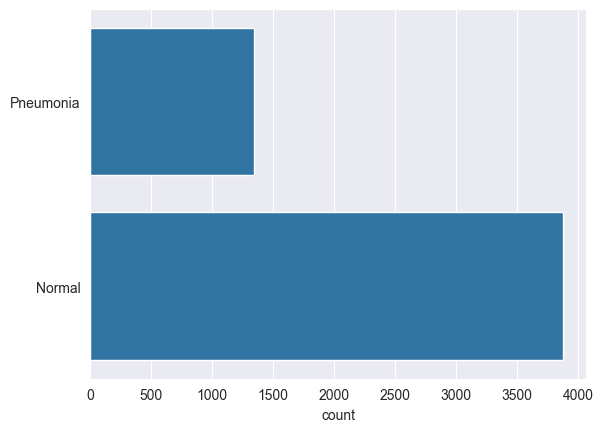

In [5]:
import seaborn as sns

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        



Text(0.5, 1.0, 'NORMAL')

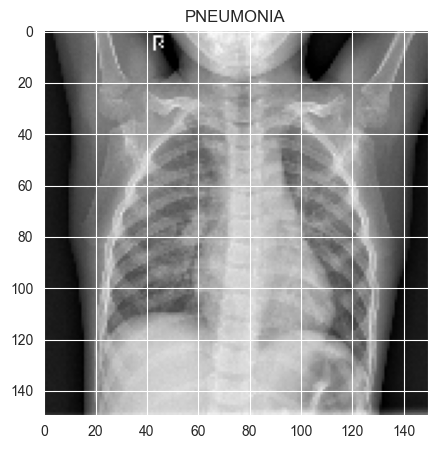

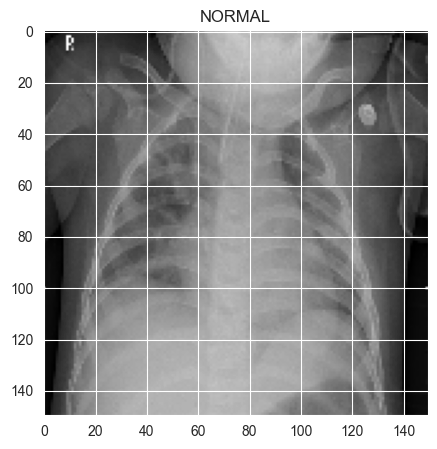

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])



In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)



In [9]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization


model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [16]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
earlystop_loss = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs = 50,
    validation_data = datagen.flow(x_val, y_val),
    # callbacks = [learning_rate_reduction]
    callbacks = [earlystop_loss]
)

Epoch 1/50
163/163 [==============================] - 14s 78ms/step - loss: 0.3110 - accuracy: 0.8871 - val_loss: 10.8914 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 13s 76ms/step - loss: 0.2075 - accuracy: 0.9172 - val_loss: 3.2805 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 12s 76ms/step - loss: 0.1884 - accuracy: 0.9298 - val_loss: 9.1733 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 13s 77ms/step - loss: 0.1788 - accuracy: 0.9323 - val_loss: 1.5445 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 12s 76ms/step - loss: 0.1474 - accuracy: 0.9427 - val_loss: 1.4407 - val_accuracy: 0.5000
Epoch 6/50
163/163 [==============================] - 12s 76ms/step - loss: 0.1515 - accuracy: 0.9473 - val_loss: 7.6789 - val_accuracy: 0.5000
Epoch 7/50
163/163 [==============================] - 13s 77ms/step - loss: 0.1420 - accuracy: 0.9494 - val_loss: 2.9891 - val_accuracy

KeyboardInterrupt: 

In [12]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 25ms/step - loss: 0.2577 - accuracy: 0.9151
Loss of the model is -  0.2577034831047058
20/20 [==============================] - 0s 20ms/step - loss: 0.2577 - accuracy: 0.9151
Accuracy of the model is -  91.50640964508057 %


In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:


i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

